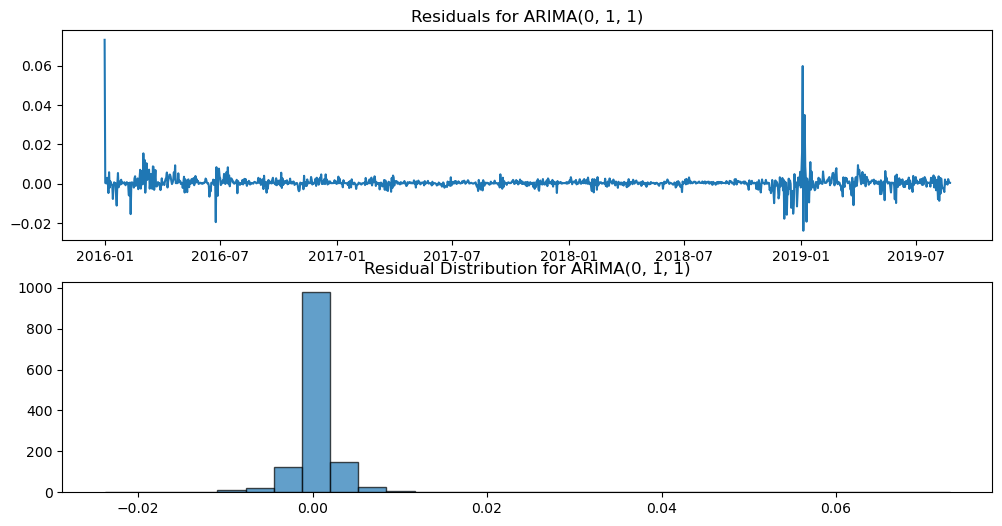

,Order,MSE,AIC,BIC
0,"(1, 1, 0)",0.028538,-11448.940498,-11438.553126
1,"(0, 1, 1)",0.028531,-11441.020519,-11430.633148
2,"(1, 1, 1)",0.028539,-11446.999037,-11431.417979


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.simplefilter("ignore")

# Load the dataset
file_path = "Project1 Data.csv"  
df = pd.read_csv(file_path)

# Convert Date column to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select target index for forecasting
ts = df['LL100'].interpolate()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1)).flatten()
ts_scaled = pd.Series(ts_scaled, index=ts.index)

# Define candidate ARIMA orders
arima_orders = [(1,1,0), (0,1,1), (1,1,1)]

# Split data into train and test sets
train_size = int(len(ts_scaled) * 0.8)
train, test = ts_scaled[:train_size], ts_scaled[train_size:]

# Initialize tracking variables
best_model = None
best_order = None
# Store metrics for all tested models
model_metrics = []

# Compute BIC for all models and analyze residuals
model_metrics = []

residuals_dict = {}

for order in arima_orders:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        
        mse = mean_squared_error(test, predictions)
        aic = model_fit.aic
        bic = model_fit.bic

        model_metrics.append({'Order': order, 'MSE': mse, 'AIC': aic, 'BIC': bic})
        
        # Store residuals for analysis
        residuals_dict[order] = model_fit.resid

    except Exception as e:
        model_metrics.append({'Order': order, 'MSE': None, 'AIC': None, 'BIC': None})

# Convert to DataFrame and display results
metrics_df = pd.DataFrame(model_metrics)


# Plot residuals for the best model (ARIMA(0,1,1))
best_order = (0,1,1)
residuals = residuals_dict[best_order]

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(residuals)
plt.title(f'Residuals for ARIMA{best_order}')

plt.subplot(2,1,2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Residual Distribution for ARIMA{best_order}')
plt.show()

# Summary statistics of residuals
residuals.describe()
metrics_df


In [83]:
metrics_df.to_clipboard()

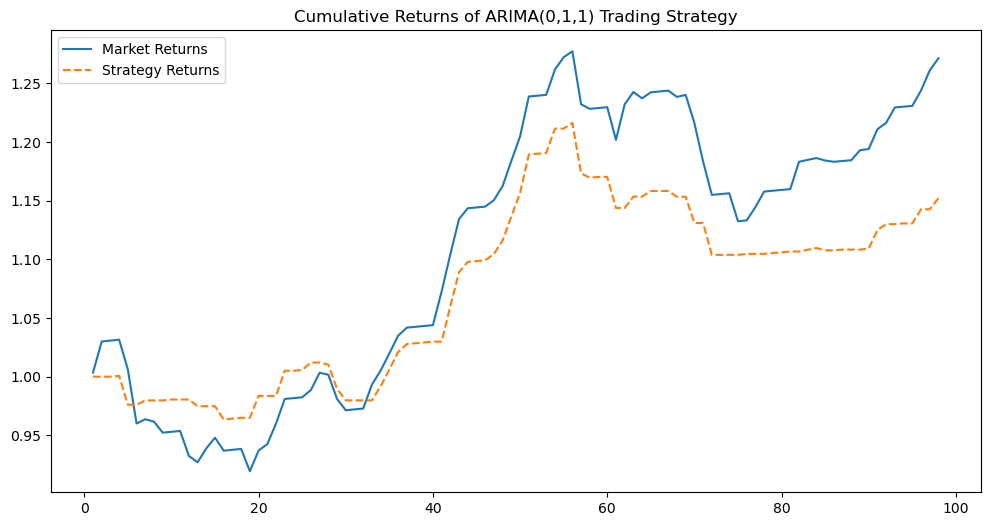

In [84]:
# Backtesting ARIMA(0,1,1) model

# Define backtest period (last 100 days)
backtest_period = 100
predictions_scaled = []
actuals_scaled = []

# Iterate over the backtest period
for i in range(len(ts_scaled) - backtest_period, len(ts_scaled) - 1):
    train_data = ts_scaled[:i]  # Train up to time step i
    model_scaled = ARIMA(train_data, order=(0,1,1))  # Best model order
    model_scaled_fit = model_scaled.fit()
    forecast_scaled = model_scaled_fit.forecast(steps=1)[0]  # Predict 1 step ahead

    predictions_scaled.append(forecast_scaled)
    actuals_scaled.append(ts_scaled.iloc[i + 1])

# Create results DataFrame
backtest_results_scaled = pd.DataFrame({
    'Actual Price (Normalized)': actuals_scaled,
    'Predicted Price (Normalized)': predictions_scaled
})

# Compute daily returns
backtest_results_scaled['Actual Returns'] = backtest_results_scaled['Actual Price (Normalized)'].pct_change()
backtest_results_scaled['Predicted Returns'] = backtest_results_scaled['Predicted Price (Normalized)'].pct_change()

# Generate trading signals: Buy if predicted return is positive, Sell otherwise
backtest_results_scaled['Signal'] = backtest_results_scaled['Predicted Returns'].apply(lambda x: 'Buy' if x > 0 else 'Sell')

# Compute strategy returns: Buy means taking actual return, Sell means 0 return
backtest_results_scaled['Strategy Returns'] = backtest_results_scaled['Actual Returns'] * (backtest_results_scaled['Signal'].shift(1) == 'Buy')

# Compute cumulative returns
backtest_results_scaled['Cumulative Market Returns'] = (1 + backtest_results_scaled['Actual Returns']).cumprod()
backtest_results_scaled['Cumulative Strategy Returns'] = (1 + backtest_results_scaled['Strategy Returns']).cumprod()



# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_scaled['Cumulative Market Returns'], label='Market Returns')
plt.plot(backtest_results_scaled['Cumulative Strategy Returns'], label='Strategy Returns', linestyle='dashed')
plt.legend()
plt.title("Cumulative Returns of ARIMA(0,1,1) Trading Strategy")
plt.show()


In [85]:
# Compute MSE for backtesting predictions
arimax_backtest_mse = mean_squared_error(
    backtest_results_scaled['Actual Price (Normalized)'], 
    backtest_results_scaled['Predicted Price (Normalized)']
)

# Return the MSE value
arimax_backtest_mse


0.0002898247599429878

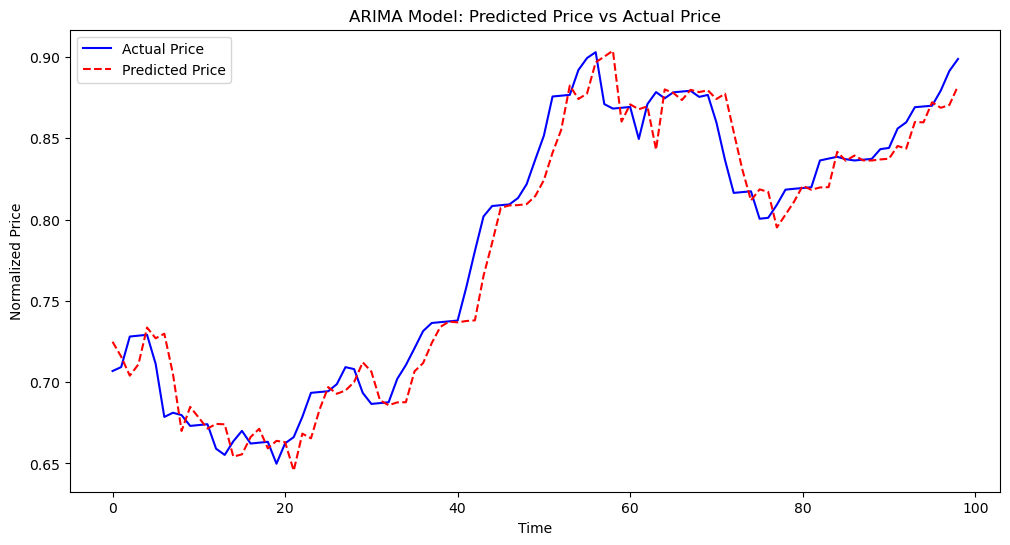

In [86]:
# Plot Predicted Price vs Actual Price
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_scaled.index, backtest_results_scaled['Actual Price (Normalized)'], label='Actual Price', color='blue')
plt.plot(backtest_results_scaled.index, backtest_results_scaled['Predicted Price (Normalized)'], label='Predicted Price', color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("ARIMA Model: Predicted Price vs Actual Price")
plt.legend()
plt.show()


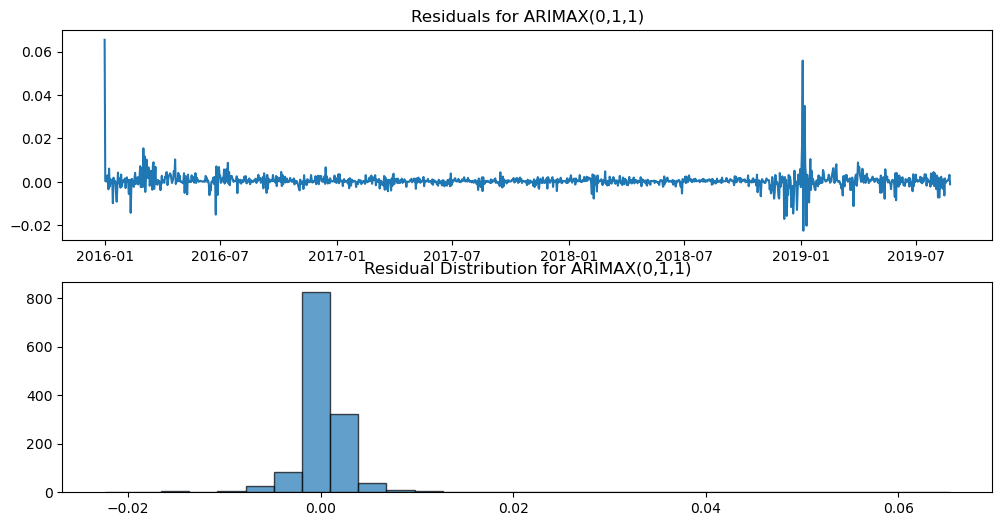

0.0263286863504244

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Select the target variable (LL100) and exogenous variables
exog_vars = ['SP500', 'INDU', 'CONS', 'HLTH', 'INFT', 'UTIL', 'FINA', 'EE']
exog_data = df[exog_vars].interpolate().fillna(method='bfill')

# Normalize exogenous variables using MinMaxScaler
scaler_exog = MinMaxScaler()
exog_scaled = pd.DataFrame(scaler_exog.fit_transform(exog_data), columns=exog_data.columns, index=exog_data.index)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(ts_scaled) * 0.8)
train_y, test_y = ts_scaled[:train_size], ts_scaled[train_size:]
train_exog, test_exog = exog_scaled[:train_size], exog_scaled[train_size:]

# Train ARIMAX model (Using best order from previous ARIMA analysis: (0,1,1))
arimax_model = SARIMAX(train_y, exog=train_exog, order=(0,1,1))
arimax_fit = arimax_model.fit()

# Forecast using test exogenous variables
arimax_predictions = arimax_fit.forecast(steps=len(test_y), exog=test_exog)

# Compute MSE
arimax_mse = mean_squared_error(test_y, arimax_predictions)

# Plot residuals
residuals_arimax = arimax_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(residuals_arimax)
plt.title('Residuals for ARIMAX(0,1,1)')

plt.subplot(2,1,2)
plt.hist(residuals_arimax, bins=30, edgecolor='black', alpha=0.7)
plt.title('Residual Distribution for ARIMAX(0,1,1)')
plt.show()


# Return MSE
arimax_mse

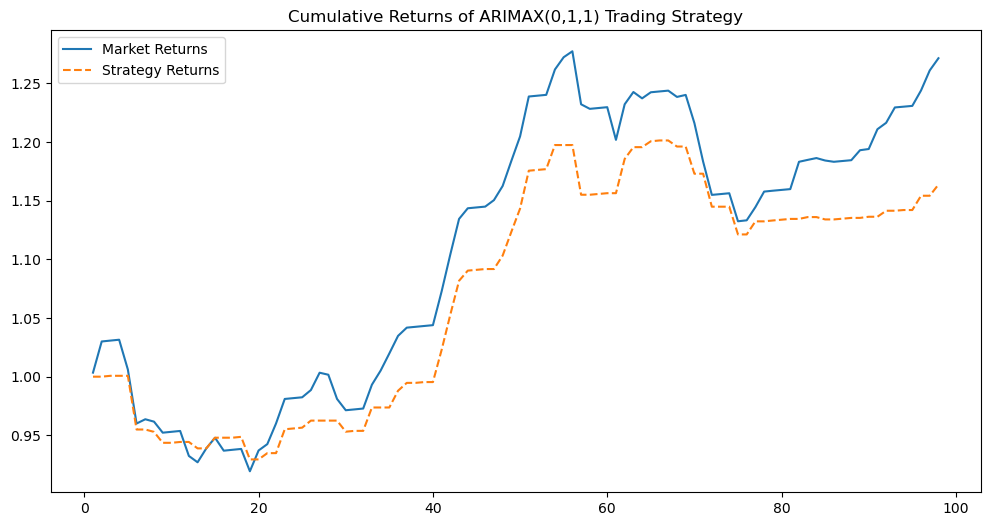

In [88]:
# Backtesting ARIMAX(0,1,1) model

# Define backtest period (last 100 days)
backtest_period = 100
predictions_scaled_arimax = []
actuals_scaled_arimax = []

# Iterate over the backtest period using rolling window training
for i in range(len(ts_scaled) - backtest_period, len(ts_scaled) - 1):
    train_data = ts_scaled[:i]  # Train on data up to time step i
    train_exog_data = exog_scaled[:i]  # Corresponding exogenous data

    model_arimax = SARIMAX(train_data, exog=train_exog_data, order=(0,1,1))
    model_arimax_fit = model_arimax.fit()
    
    # Predict 1 step ahead using the next day's exogenous data
    forecast_scaled = model_arimax_fit.forecast(steps=1, exog=exog_scaled.iloc[i+1:i+2])[0]

    predictions_scaled_arimax.append(forecast_scaled)
    actuals_scaled_arimax.append(ts_scaled.iloc[i + 1])

# Create results DataFrame
backtest_results_arimax = pd.DataFrame({
    'Actual Price (Normalized)': actuals_scaled_arimax,
    'Predicted Price (Normalized)': predictions_scaled_arimax
})

# Compute daily returns
backtest_results_arimax['Actual Returns'] = backtest_results_arimax['Actual Price (Normalized)'].pct_change()
backtest_results_arimax['Predicted Returns'] = backtest_results_arimax['Predicted Price (Normalized)'].pct_change()

# Generate trading signals: Buy if predicted return is positive, Sell otherwise
backtest_results_arimax['Signal'] = backtest_results_arimax['Predicted Returns'].apply(lambda x: 'Buy' if x > 0 else 'Sell')

# Compute strategy returns: Buy means taking actual return, Sell means 0 return
backtest_results_arimax['Strategy Returns'] = backtest_results_arimax['Actual Returns'] * (backtest_results_arimax['Signal'].shift(1) == 'Buy')

# Compute cumulative returns
backtest_results_arimax['Cumulative Market Returns'] = (1 + backtest_results_arimax['Actual Returns']).cumprod()
backtest_results_arimax['Cumulative Strategy Returns'] = (1 + backtest_results_arimax['Strategy Returns']).cumprod()


# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_arimax['Cumulative Market Returns'], label='Market Returns')
plt.plot(backtest_results_arimax['Cumulative Strategy Returns'], label='Strategy Returns', linestyle='dashed')
plt.legend()
plt.title("Cumulative Returns of ARIMAX(0,1,1) Trading Strategy")
plt.show()

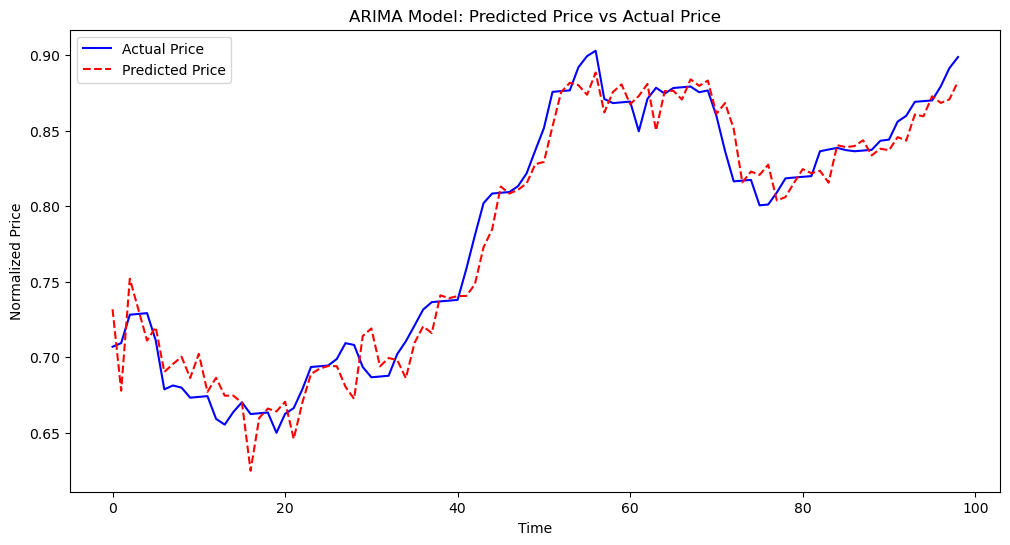

In [89]:
# Plot Predicted Price vs Actual Price
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Actual Price (Normalized)'], label='Actual Price', color='blue')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Predicted Price (Normalized)'], label='Predicted Price', color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("ARIMA Model: Predicted Price vs Actual Price")
plt.legend()
plt.show()

In [90]:
# Compute MSE for backtesting predictions
arimax_backtest_mse = mean_squared_error(
    backtest_results_arimax['Actual Price (Normalized)'], 
    backtest_results_arimax['Predicted Price (Normalized)']
)

# Return the MSE value
arimax_backtest_mse

0.0002574624852235201

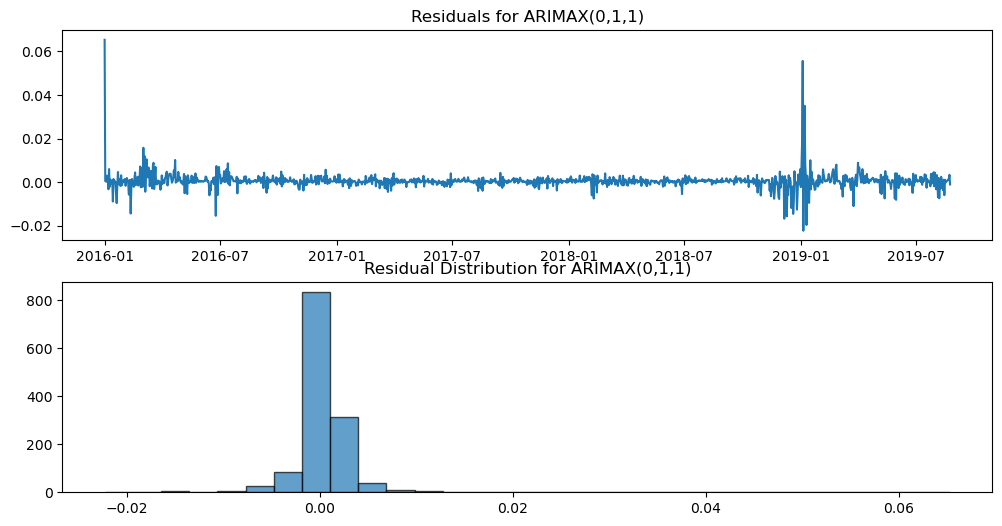

0.025475529890352667

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Select the target variable (LL100) and exogenous variables
exog_vars = ['SP500', 'INDU', 'HLTH', 'FINA']
exog_data = df[exog_vars].interpolate().fillna(method='bfill')

# Normalize exogenous variables using MinMaxScaler
scaler_exog = MinMaxScaler()
exog_scaled = pd.DataFrame(scaler_exog.fit_transform(exog_data), columns=exog_data.columns, index=exog_data.index)

# Split into training and test sets (80% train, 20% test)
train_size = int(len(ts_scaled) * 0.8)
train_y, test_y = ts_scaled[:train_size], ts_scaled[train_size:]
train_exog, test_exog = exog_scaled[:train_size], exog_scaled[train_size:]

# Train ARIMAX model (Using best order from previous ARIMA analysis: (0,1,1))
arimax_model = SARIMAX(train_y, exog=train_exog, order=(0,1,1))
arimax_fit = arimax_model.fit()

# Forecast using test exogenous variables
arimax_predictions = arimax_fit.forecast(steps=len(test_y), exog=test_exog)

# Compute MSE
arimax_mse = mean_squared_error(test_y, arimax_predictions)

# Plot residuals
residuals_arimax = arimax_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(residuals_arimax)
plt.title('Residuals for ARIMAX(0,1,1)')

plt.subplot(2,1,2)
plt.hist(residuals_arimax, bins=30, edgecolor='black', alpha=0.7)
plt.title('Residual Distribution for ARIMAX(0,1,1)')
plt.show()

# Return MSE
arimax_mse


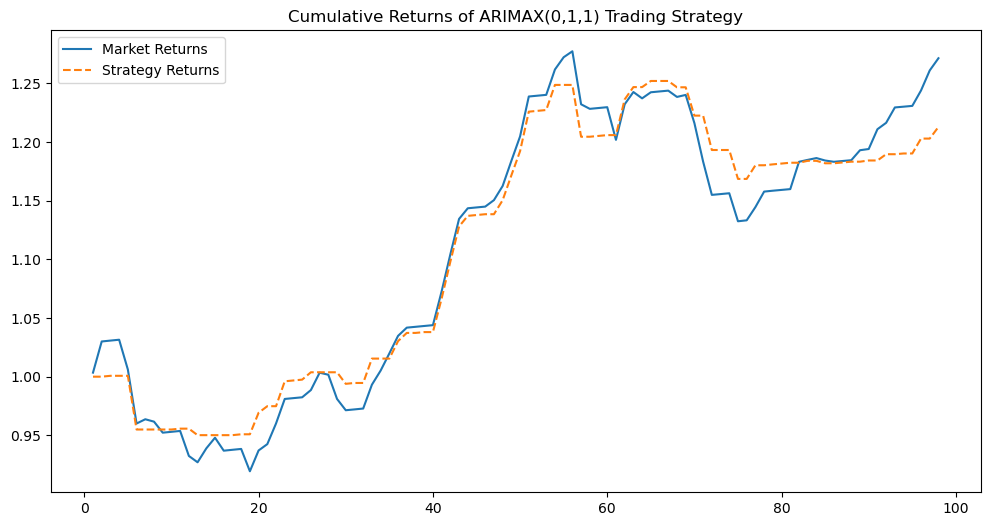

In [92]:
# Backtesting ARIMAX(0,1,1) model

# Define backtest period (last 100 days)
backtest_period = 100
predictions_scaled_arimax = []
actuals_scaled_arimax = []

# Iterate over the backtest period using rolling window training
for i in range(len(ts_scaled) - backtest_period, len(ts_scaled) - 1):
    train_data = ts_scaled[:i]  # Train on data up to time step i
    train_exog_data = exog_scaled[:i]  # Corresponding exogenous data

    model_arimax = SARIMAX(train_data, exog=train_exog_data, order=(0,1,1))
    model_arimax_fit = model_arimax.fit()
    
    # Predict 1 step ahead using the next day's exogenous data
    forecast_scaled = model_arimax_fit.forecast(steps=1, exog=exog_scaled.iloc[i+1:i+2])[0]

    predictions_scaled_arimax.append(forecast_scaled)
    actuals_scaled_arimax.append(ts_scaled.iloc[i + 1])

# Create results DataFrame
backtest_results_arimax = pd.DataFrame({
    'Actual Price (Normalized)': actuals_scaled_arimax,
    'Predicted Price (Normalized)': predictions_scaled_arimax
})

# Compute daily returns
backtest_results_arimax['Actual Returns'] = backtest_results_arimax['Actual Price (Normalized)'].pct_change()
backtest_results_arimax['Predicted Returns'] = backtest_results_arimax['Predicted Price (Normalized)'].pct_change()

# Generate trading signals: Buy if predicted return is positive, Sell otherwise
backtest_results_arimax['Signal'] = backtest_results_arimax['Predicted Returns'].apply(lambda x: 'Buy' if x > 0 else 'Sell')

# Compute strategy returns: Buy means taking actual return, Sell means 0 return
backtest_results_arimax['Strategy Returns'] = backtest_results_arimax['Actual Returns'] * (backtest_results_arimax['Signal'].shift(1) == 'Buy')

# Compute cumulative returns
backtest_results_arimax['Cumulative Market Returns'] = (1 + backtest_results_arimax['Actual Returns']).cumprod()
backtest_results_arimax['Cumulative Strategy Returns'] = (1 + backtest_results_arimax['Strategy Returns']).cumprod()


# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_arimax['Cumulative Market Returns'], label='Market Returns')
plt.plot(backtest_results_arimax['Cumulative Strategy Returns'], label='Strategy Returns', linestyle='dashed')
plt.legend()
plt.title("Cumulative Returns of ARIMAX(0,1,1) Trading Strategy")
plt.show()


In [93]:
# Compute MSE for backtesting predictions
arimax_backtest_mse = mean_squared_error(
    backtest_results_arimax['Actual Price (Normalized)'], 
    backtest_results_arimax['Predicted Price (Normalized)']
)

# Return the MSE value
arimax_backtest_mse


0.00023277665192814528

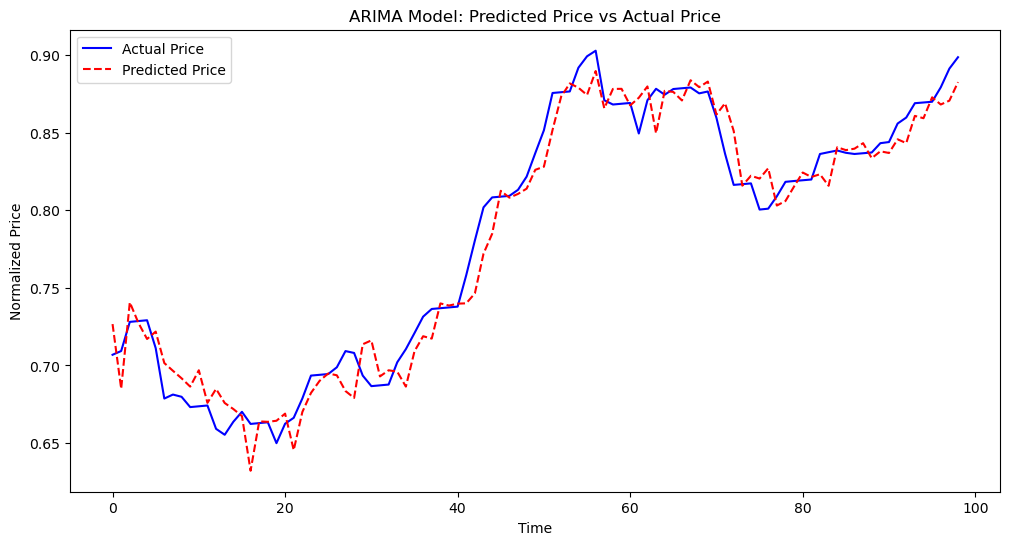

In [94]:
# Plot Predicted Price vs Actual Price
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Actual Price (Normalized)'], label='Actual Price', color='blue')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Predicted Price (Normalized)'], label='Predicted Price', color='red', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("ARIMA Model: Predicted Price vs Actual Price")
plt.legend()
plt.show()

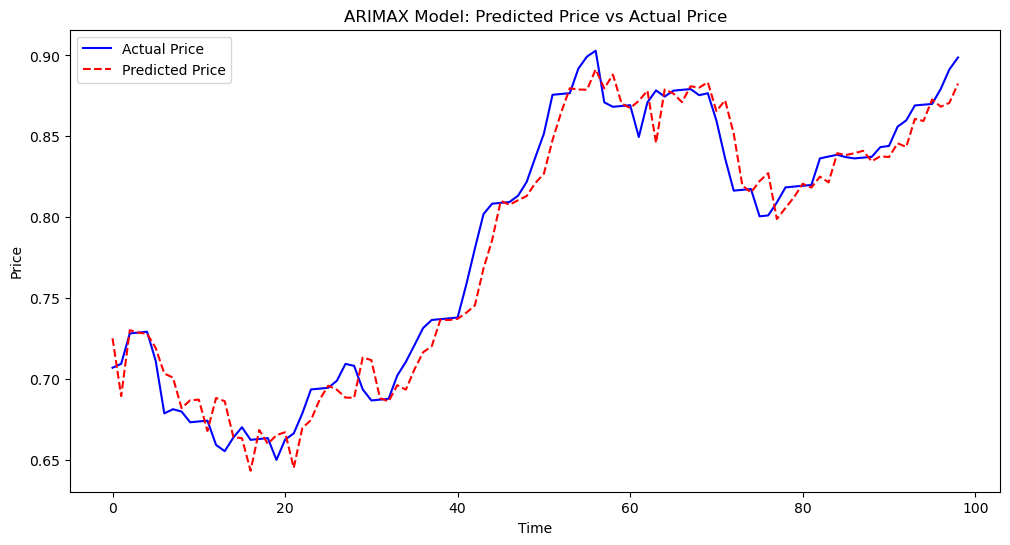

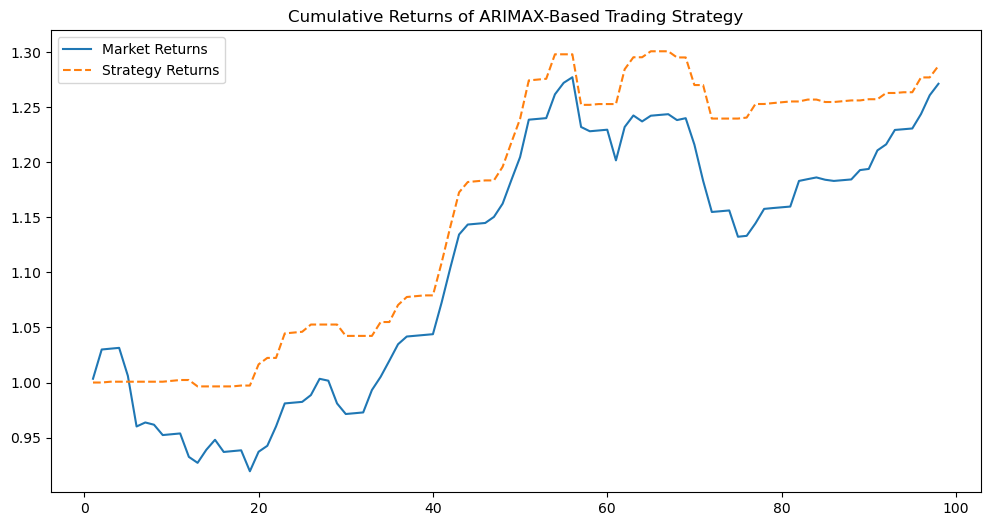

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
file_path = "Project1 Data.csv"  # Change this to actual file path
df = pd.read_csv(file_path)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Select target index for forecasting
ts = df['LL100'].interpolate()
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1)).flatten()
ts = pd.Series(ts_scaled, index=ts.index)
# Incorporate Exogenous Variables (ARIMAX) & Handle Missing Data
exog_vars = df[['SP500', 'FINA', 'INDU']]
exog_vars = exog_vars.fillna(method='ffill').fillna(method='bfill')  # Fill missing values

# Ensure data alignment
exog_vars = exog_vars.loc[ts.index]

# Perform ADF test to check stationarity
def adf_test(series):
    result = adfuller(series)
    return {'Test Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

adf_before = adf_test(ts)

# Apply first differencing
ts_diff1 = ts.diff().dropna()
adf_after = adf_test(ts_diff1)

# Fit ARIMAX model
p, d, q = 0, 1, 1  # Determined from ACF/PACF
model = ARIMA(ts, exog=exog_vars, order=(p,d,q))
model_fit = model.fit()

# Backtesting ARIMAX trading strategy
backtest_period = 100  # Use last 100 days
predictions = []
actuals = []

for i in range(len(ts) - backtest_period, len(ts) - 1):
    train_data = ts[:i]
    exog_train = exog_vars[:i]
    model = ARIMA(train_data, exog=exog_train, order=(p,d,q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1, exog=exog_vars.iloc[i+1].values.reshape(1, -1))[0]
    predictions.append(forecast)
    actuals.append(ts.iloc[i + 1])

# Create results DataFrame
backtest_results = pd.DataFrame({
    'Actual Price': actuals,
    'Predicted Price': predictions
})

# Compute daily returns
backtest_results['Actual Returns'] = backtest_results['Actual Price'].pct_change()
backtest_results['Predicted Returns'] = backtest_results['Predicted Price'].pct_change()

# Generate trading signals
backtest_results['Signal'] = backtest_results['Predicted Returns'].apply(lambda x: 'Buy' if x > 0 else 'Sell')

# Compute strategy returns
backtest_results['Strategy Returns'] = backtest_results['Actual Returns'] * (backtest_results['Signal'].shift(1) == 'Buy')

# Cumulative returns
backtest_results['Cumulative Market Returns'] = (1 + backtest_results['Actual Returns']).cumprod()
backtest_results['Cumulative Strategy Returns'] = (1 + backtest_results['Strategy Returns']).cumprod()

# Plot Predicted Price vs Actual Price
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Actual Price'], label='Actual Price', color='blue')
plt.plot(backtest_results.index, backtest_results['Predicted Price'], label='Predicted Price', color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ARIMAX Model: Predicted Price vs Actual Price")
plt.legend()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Cumulative Market Returns'], label='Market Returns')
plt.plot(backtest_results.index, backtest_results['Cumulative Strategy Returns'], label='Strategy Returns', linestyle='dashed')
plt.legend()
plt.title("Cumulative Returns of ARIMAX-Based Trading Strategy")
plt.show()


In [96]:
# Compute MSE for backtesting predictions
arimax_backtest_mse = mean_squared_error(
    backtest_results['Actual Price'], 
    backtest_results['Predicted Price']
)

# Return the MSE value
arimax_backtest_mse


0.00022730400896210954

Iteration:      1,   Func. Count:      6,   Neg. LLF: 168390.10574019258
Iteration:      2,   Func. Count:     12,   Neg. LLF: 13337528345.128345
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4988.902459054638
Iteration:      4,   Func. Count:     23,   Neg. LLF: 53022.47100524156
Iteration:      5,   Func. Count:     33,   Neg. LLF: 612316.4536375372
Iteration:      6,   Func. Count:     40,   Neg. LLF: 11519.227982426151
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3757.842149509831
Iteration:      8,   Func. Count:     51,   Neg. LLF: 12021.441942171046
Iteration:      9,   Func. Count:     57,   Neg. LLF: 11518.658038826421
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3805.838385968735
Iteration:     11,   Func. Count:     69,   Neg. LLF: 3747.458001928128
Iteration:     12,   Func. Count:     74,   Neg. LLF: 3746.596772938357
Iteration:     13,   Func. Count:     79,   Neg. LLF: 3741.7182696437694
Iteration:     14,   Func. Count:     84,   Neg. LLF: 3729

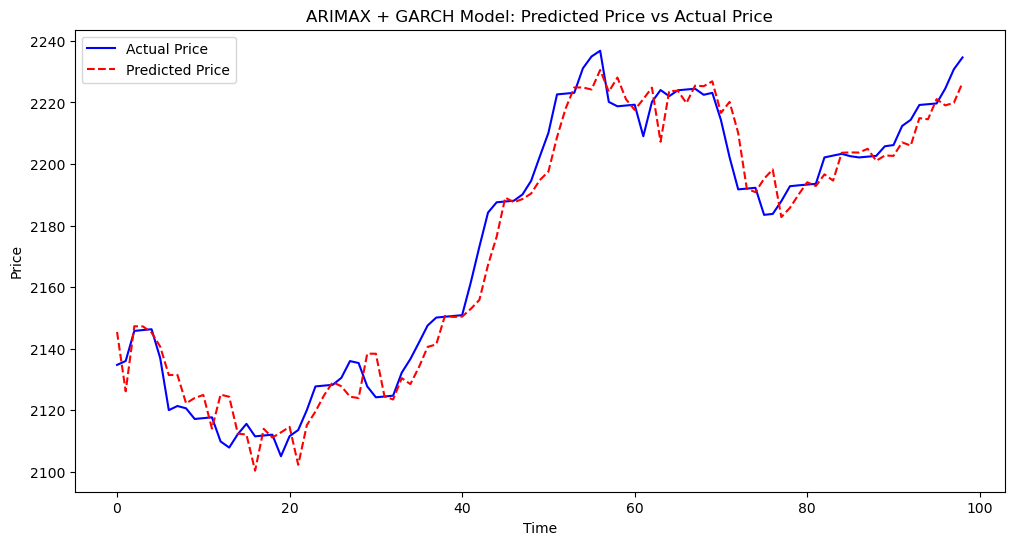

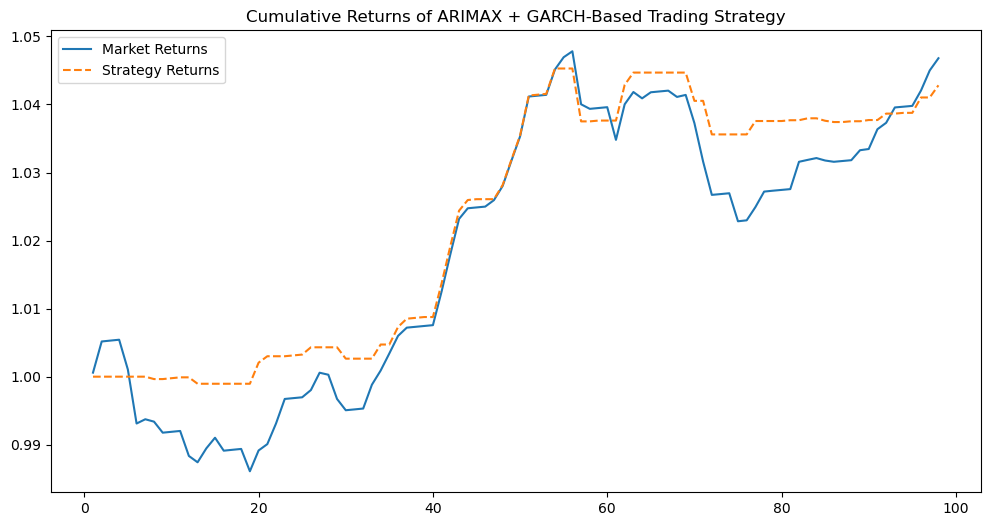

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

# Load the dataset
file_path = "Project1 Data.csv"  # Change this to actual file path
df = pd.read_csv(file_path)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Select target index for forecasting
ts = df['LL100'].interpolate()

# Incorporate Exogenous Variables (ARIMAX) & Handle Missing Data
exog_vars = df[['SP500', 'FINA', 'INDU']]
exog_vars = exog_vars.fillna(method='ffill').fillna(method='bfill')  # Fill missing values

# Ensure data alignment
exog_vars = exog_vars.loc[ts.index]

# Perform ADF test to check stationarity
def adf_test(series):
    result = adfuller(series)
    return {'Test Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

adf_before = adf_test(ts)

# Apply first differencing
ts_diff1 = ts.diff().dropna()
adf_after = adf_test(ts_diff1)

# Fit ARIMAX model
p, d, q = 1, 1, 1  # Determined from ACF/PACF
model = ARIMA(ts, exog=exog_vars, order=(p,d,q))
model_fit = model.fit()

# Fit GARCH model to capture volatility
residuals = model_fit.resid.dropna()
garch_model = arch_model(residuals, vol='Garch', p=1, q=1).fit()

# Forecast volatility
volatility_forecast = garch_model.forecast(start=0).variance[-1:].values[0]

# Backtesting ARIMAX + GARCH trading strategy
backtest_period = 100  # Use last 100 days
predictions = []
actuals = []
volatility_forecasts = []

for i in range(len(ts) - backtest_period, len(ts) - 1):
    train_data = ts[:i]
    exog_train = exog_vars[:i]
    model = ARIMA(train_data, exog=exog_train, order=(p,d,q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1, exog=exog_vars.iloc[i+1].values.reshape(1, -1))[0]
    predictions.append(forecast)
    actuals.append(ts.iloc[i + 1])
    
    # Fit GARCH model on residuals
    residuals = model_fit.resid.dropna()
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1).fit(disp='off')
    volatility_forecast = garch_model.forecast(start=0).variance[-1:].values[0]
    volatility_forecasts.append(volatility_forecast)

# Create results DataFrame
backtest_results = pd.DataFrame({
    'Actual Price': actuals,
    'Predicted Price': predictions,
    'Forecasted Volatility': volatility_forecasts
})

# Compute daily returns
backtest_results['Actual Returns'] = backtest_results['Actual Price'].pct_change()
backtest_results['Predicted Returns'] = backtest_results['Predicted Price'].pct_change()

# Generate trading signals with risk-adjusted position sizing
backtest_results['Signal'] = np.where(
    (backtest_results['Predicted Returns'] > 0) & (backtest_results['Forecasted Volatility'] < np.mean(volatility_forecasts)), 'Buy', 'Sell'
)

# Compute strategy returns
backtest_results['Strategy Returns'] = backtest_results['Actual Returns'] * (backtest_results['Signal'].shift(1) == 'Buy')

# Cumulative returns
backtest_results['Cumulative Market Returns'] = (1 + backtest_results['Actual Returns']).cumprod()
backtest_results['Cumulative Strategy Returns'] = (1 + backtest_results['Strategy Returns']).cumprod()

# Plot Predicted Price vs Actual Price
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Actual Price'], label='Actual Price', color='blue')
plt.plot(backtest_results.index, backtest_results['Predicted Price'], label='Predicted Price', color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ARIMAX + GARCH Model: Predicted Price vs Actual Price")
plt.legend()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Cumulative Market Returns'], label='Market Returns')
plt.plot(backtest_results.index, backtest_results['Cumulative Strategy Returns'], label='Strategy Returns', linestyle='dashed')
plt.legend()
plt.title("Cumulative Returns of ARIMAX + GARCH-Based Trading Strategy")
plt.show()


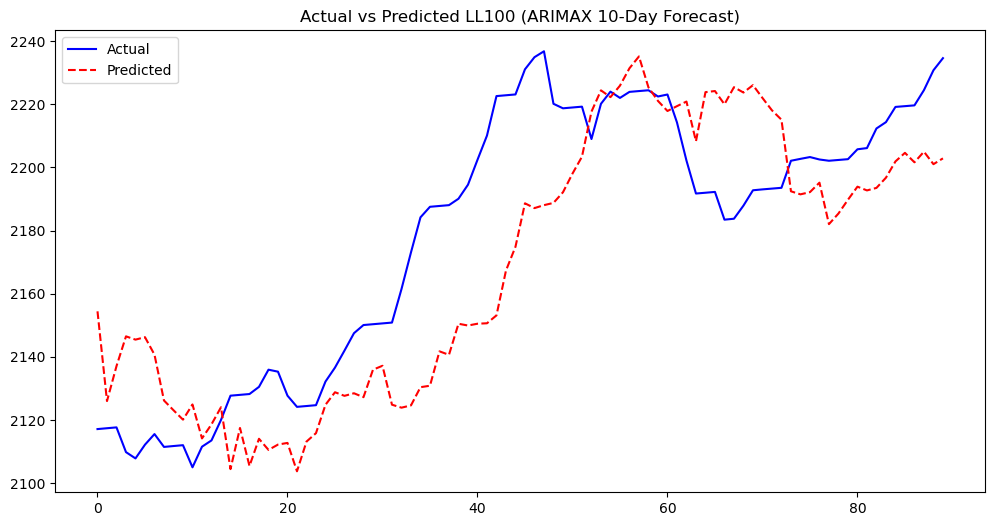

797.8103110145139

In [98]:
# Train ARIMAX(0,1,1) model and forecast the next 10 days

# Define train-test split (80% train, 20% test)
train_size = int(len(ts) * 0.8)
train_y, test_y = ts[:train_size], ts[train_size:]
train_exog, test_exog = exog_vars[:train_size], exog_vars[train_size:]

# Fit ARIMAX model
arimax_model = ARIMA(train_y, exog=train_exog, order=(0,1,1))
arimax_fit = arimax_model.fit()

# Forecast the next 10 days using exogenous variables
forecast_horizon = 10
predictions_arimax_10 = arimax_fit.forecast(steps=len(test_y), exog=test_exog)

# Compute MSE for each forecasted day (1-day ahead, 2-day ahead, ..., 10-day ahead)
mse_per_day = []
for i in range(1, forecast_horizon + 1):
    if len(test_y) >= i:
        mse = mean_squared_error(test_y[i-1:], predictions_arimax_10[:len(test_y)-i+1])
        mse_per_day.append({'Day': i, 'MSE': mse})

# Convert to DataFrame
mse_per_day_df = pd.DataFrame(mse_per_day)


# Backtesting using 10-day forecasts
backtest_period = 100
predictions_scaled_arimax_10 = []
actuals_scaled_arimax_10 = []

# Iterate over the backtest period using a rolling window
for i in range(len(ts) - backtest_period, len(ts) - forecast_horizon):
    train_data = ts[:i]  # Train on data up to time step i
    train_exog_data = exog_vars[:i]  # Corresponding exogenous data

    model_arimax = ARIMA(train_data, exog=train_exog_data, order=(0,1,1))
    model_arimax_fit = model_arimax.fit()

    # Predict next 10 days using the next 10 days' exogenous data
    forecast_scaled_10 = model_arimax_fit.forecast(steps=forecast_horizon, exog=exog_vars.iloc[i:i+forecast_horizon])
    
    # Store the first forecasted value (mimicking real-time execution)
    predictions_scaled_arimax_10.append(forecast_scaled_10[0])
    actuals_scaled_arimax_10.append(ts.iloc[i + forecast_horizon])

# Create backtesting results DataFrame
backtest_results_arimax_10 = pd.DataFrame({
    'Actual Price': actuals_scaled_arimax_10,
    'Predicted Price': predictions_scaled_arimax_10
})

# Compute MSE for backtesting
arimax_backtest_mse_10 = mean_squared_error(
    backtest_results_arimax_10['Actual Price'], 
    backtest_results_arimax_10['Predicted Price']
)



# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(backtest_results_arimax_10.index, backtest_results_arimax_10['Actual Price'], label="Actual", color='blue')
plt.plot(backtest_results_arimax_10.index, backtest_results_arimax_10['Predicted Price'], label="Predicted", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted LL100 (ARIMAX 10-Day Forecast)")
plt.show()

# Return the computed backtest MSE
arimax_backtest_mse_10


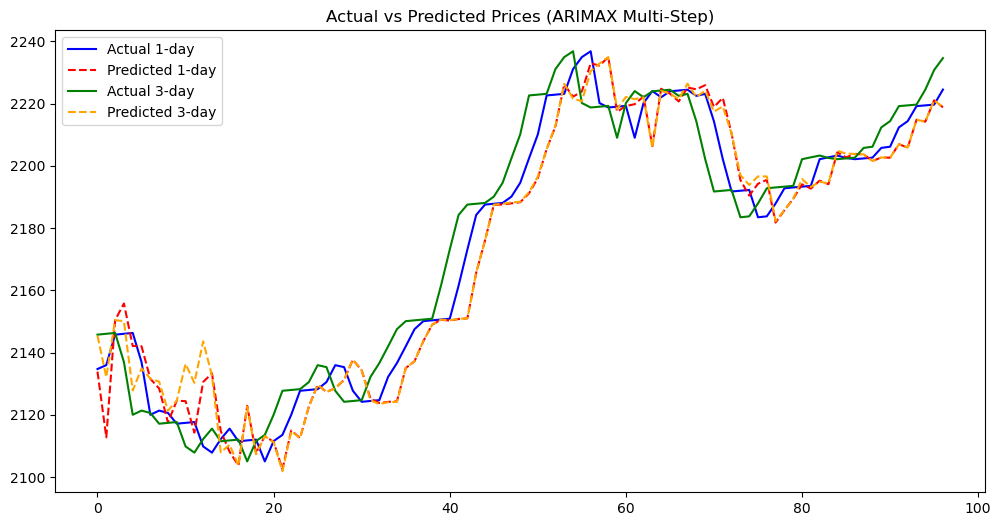

{1: 81.80308924784785, 2: 136.44701276930596, 3: 199.26150883234368}

In [99]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define backtest period (last 100 days)
backtest_period = 100
rolling_window = 200  # Use the last 200 observations for training

# Store results
predictions_arimax = []
actuals_arimax = []
mse_per_day = {i: [] for i in range(1, 4)}  # Store MSE for each forecast horizon (1 to 10 days ahead)

# Perform rolling backtesting with multi-step predictions
for i in range(len(ts) - backtest_period, len(ts) - 3):
    # Define rolling training window
    train_data = ts[max(0, i - rolling_window):i]
    train_exog_data = exog_vars[max(0, i - rolling_window):i]

    # Fit ARIMAX model
    model_arimax = SARIMAX(train_data, exog=train_exog_data, order=(0,1,1))
    model_arimax_fit = model_arimax.fit(disp=False)

    # Perform 10-step rolling forecast
    exog_future = exog_vars.iloc[i+1:i+4]  # Exogenous variables for next 10 days
    forecast_scaled = model_arimax_fit.forecast(steps=3, exog=exog_future)

    # Store results
    actual_values = ts.iloc[i+1:i+4].values
    predictions_arimax.append(forecast_scaled.values)
    actuals_arimax.append(actual_values)

    # Compute MSE for each step ahead (1-day to 10-day)
    for j in range(3):
        mse_per_day[j + 1].append((forecast_scaled[j] - actual_values[j]) ** 2)

# Convert MSE to final per-day averages
mse_final = {key: np.mean(values) for key, values in mse_per_day.items()}

# Create results DataFrame for analysis
backtest_results_arimax = pd.DataFrame({
    'Actual 1-day': [x[0] for x in actuals_arimax],
    'Predicted 1-day': [x[0] for x in predictions_arimax],
    'Actual 2-day': [x[1] for x in actuals_arimax],
    'Predicted 2-day': [x[1] for x in predictions_arimax],
    'Actual 3-day': [x[2] for x in actuals_arimax],
    'Predicted 3-day': [x[2] for x in predictions_arimax],
})

# Display the MSE results
mse_df = pd.DataFrame(list(mse_final.items()), columns=['Forecast Horizon (Days)', 'MSE'])


# Plot actual vs predicted values for different forecast horizons
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Actual 1-day'], label='Actual 1-day', color='blue')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Predicted 1-day'], label='Predicted 1-day', linestyle='dashed', color='red')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Actual 3-day'], label='Actual 3-day', color='green')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Predicted 3-day'], label='Predicted 3-day', linestyle='dashed', color='orange')
plt.legend()
plt.title("Actual vs Predicted Prices (ARIMAX Multi-Step)")
plt.show()

# Return the computed per-day MSE values
mse_final


In [100]:
backtest_results_arimax

,Actual 1-day,Predicted 1-day,Actual 2-day,Predicted 2-day,Actual 3-day,Predicted 3-day
0,2134.72,2133.879378,2135.98,2126.121080,2145.76,2145.422382
1,2135.98,2112.773864,2145.76,2132.132266,2146.04,2132.132266
2,2145.76,2150.431110,2146.04,2150.431110,2146.31,2150.431110
3,2146.04,2155.773865,2146.31,2155.773865,2136.96,2150.054380
4,2146.31,2142.115025,2136.96,2136.567554,2120.02,2127.830209
...,...,...,...,...,...,...
92,2214.36,2205.836745,2219.18,2205.836745,2219.42,2205.836745
93,2219.18,2214.799115,2219.42,2214.799115,2219.67,2214.799115
94,2219.42,2214.194998,2219.67,2214.194998,2224.50,2214.194998
95,2219.67,2221.053569,2224.50,2221.053569,2230.79,2221.053569


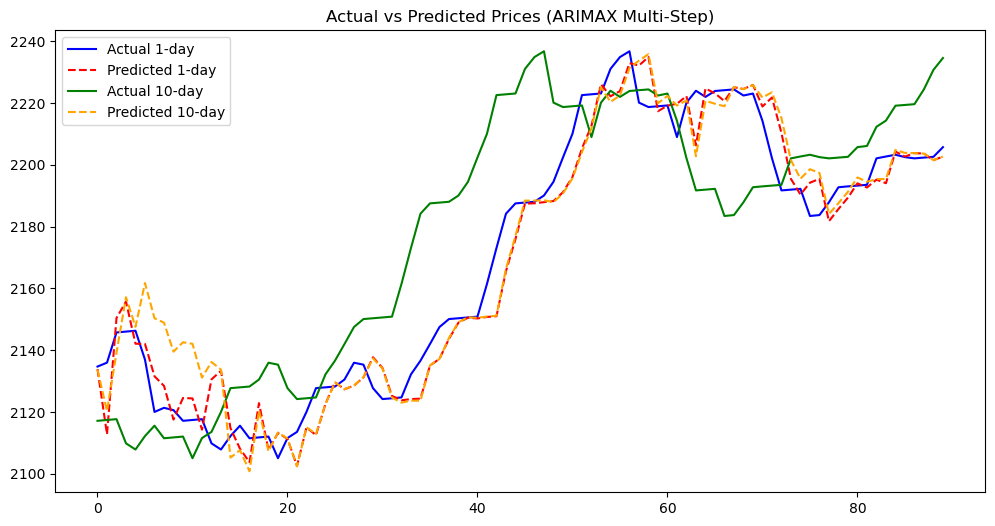

{1: 85.99718736590322,
 2: 141.11794364627528,
 3: 204.2364101812806,
 4: 281.1541705668827,
 5: 368.3128974350168,
 6: 448.25892420112723,
 7: 545.0321654778606,
 8: 649.6778150016368,
 9: 755.0107129307635,
 10: 874.2743801461204}

In [101]:
# Re-run multi-step ARIMAX forecasting with corrected model (No SARIMAX)
from statsmodels.tsa.arima.model import ARIMA

# Define backtest period (last 100 days)
backtest_period = 100
rolling_window = 200  # Use last 200 observations for training

# Store results
predictions_arimax = []
actuals_arimax = []
mse_per_day = {i: [] for i in range(1, 11)}  # Store MSE for each forecast horizon (1 to 10 days ahead)

# Perform rolling backtesting with multi-step predictions using ARIMAX
for i in range(len(ts) - backtest_period, len(ts) - 10):
    # Define rolling training window
    train_data = ts[max(0, i - rolling_window):i]
    train_exog_data = exog_vars[max(0, i - rolling_window):i]

    # Fit ARIMAX model
    model_arimax = ARIMA(train_data, exog=train_exog_data, order=(0,1,1))
    model_arimax_fit = model_arimax.fit()

    # Perform 10-step rolling forecast using actual exogenous variables
    exog_future = exog_vars.iloc[i+1:i+11]  # Exogenous variables for next 10 days
    forecast_scaled = model_arimax_fit.forecast(steps=10, exog=exog_future)

    # Store results
    actual_values = ts.iloc[i+1:i+11].values
    predictions_arimax.append(forecast_scaled.values)
    actuals_arimax.append(actual_values)

    # Compute MSE for each step ahead (1-day to 10-day)
    for j in range(10):
        mse_per_day[j + 1].append((forecast_scaled[j] - actual_values[j]) ** 2)

# Convert MSE to final per-day averages
mse_final = {key: np.mean(values) for key, values in mse_per_day.items()}

# Create results DataFrame for analysis
backtest_results_arimax = pd.DataFrame({
    'Actual 1-day': [x[0] for x in actuals_arimax],
    'Predicted 1-day': [x[0] for x in predictions_arimax],
    'Actual 5-day': [x[4] for x in actuals_arimax],
    'Predicted 5-day': [x[4] for x in predictions_arimax],
    'Actual 10-day': [x[9] for x in actuals_arimax],
    'Predicted 10-day': [x[9] for x in predictions_arimax],
})

# Display the MSE results
mse_df = pd.DataFrame(list(mse_final.items()), columns=['Forecast Horizon (Days)', 'MSE'])


# Plot actual vs predicted values for different forecast horizons
plt.figure(figsize=(12, 6))
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Actual 1-day'], label='Actual 1-day', color='blue')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Predicted 1-day'], label='Predicted 1-day', linestyle='dashed', color='red')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Actual 10-day'], label='Actual 10-day', color='green')
plt.plot(backtest_results_arimax.index, backtest_results_arimax['Predicted 10-day'], label='Predicted 10-day', linestyle='dashed', color='orange')
plt.legend()
plt.title("Actual vs Predicted Prices (ARIMAX Multi-Step)")
plt.show()

# Return the computed per-day MSE values
mse_final
